# Multi-aircraft carrier landing with Aviator

This tutorial demonstrates how to plan a multi-aircraft mission using Python, PySTK, and Aviator. It is inspired by a Python example included with the STK install.

## What is an Aviator basic maneuver?

In Aviator, a basic maneuver is a kind of procedure consisting of a single action undertaken by an aircraft. It is unlike most procedures in Aviator, which represent sets of actions that together comprise a common flying procedure. A basic maneuver is the product of interactions between the horizontal and vertical plane strategies, the speed control strategy, and the aerodynamic and propulsion aspects of the aircraft. The horizontal/navigation strategy of a basic maneuver defines the primary action that the aircraft will perform. Some horizontal/navigation strategies allow the specification of a vertical/profile strategy, while others (identified as 3D) determine both the horizontal and vertical maneuvering of the aircraft.

There are over 25 basic maneuvers included with Aviator, including barrel rolls, loops, stationkeeping maneuvers, and weaves. This example uses basic maneuvers including stationkeeping maneuvers, in which the aircraft orbits a point relative to an object, relative course maneuvers, in which the aircraft flies to a constant relative course to another object, and intercept maneuvers, in which the aircraft attempts to intercept a moving object. Each type of basic maneuver has its own configuration options, allowing the customization of a wide variety of specific behaviors.

## Problem statement

Two fighter jets leave from Oceana Naval Air Station (latitude $36.822744^\circ$, longitude $-76.031892^\circ$) and fly to an aircraft carrier, the USS Abraham Lincoln, which is sailing off of the coast near the station. The ship sails between 3 waypoints, located at ($36.64988281^\circ$, $-75.11230361^\circ$), ($36.63713768^\circ$, $-74.87339587^\circ$), and ($36.65454874^\circ$, $-75.29117133^\circ$), with a constant speed of $0.01543333$ km/sec throughout its route. The lead aircraft flies a mission consisting of two phases. During the first phase, it takes off from Oceana Naval Air Station, then flies an enroute procedure to climb to $20000$ ft and arrive at the ship on a course of $135^\circ$, and then flies a second enroute procedure to maintain its bearing while descending to $10000$ ft. The aircraft flies a second stationkeeping phase, consisting of a stationkeeping basic maneuver of $5$ left turns around the ship, a relative course basic maneuver maintaining a course of $0^\circ$ with the ship, another relative course maneuver maintaining a course of $180^\circ$ with the ship, and finally a landing on the ship. The lead aircraft flies in formation with a second wing fighter jet, which flies a mission consisting of a single phase. The wing aircraft begins its involvement in the mission already in flight at a waypoint south of the lead aircraft, located at a latitude of $36.3174^\circ$ and a longitude of $-75.4974^\circ$. The aircraft's first procedure consists of an enroute procedure, starting from the waypoint and flying a course of $340.691^\circ$. The wing aircraft then flies a relative bearing basic maneuver to intercept the leader, then a rendezvous maneuver to meet with the lead aircraft, then a stationkeeping maneuver to maintain formation consisting of $5$ left turns, and finally a stationkeeping maneuver consisting of a single left turn.

Model the flights of the aircraft to determine at what time the lead aircraft lands on the ship and the wing aircraft's altitude when the lead lands.

## Launch a new STK instance

Start by launching a new STK instance. In this example, STKEngine is used.

In [1]:
from ansys.stk.core.stkengine import STKEngine


stk = STKEngine.start_application(no_graphics=False)
print(f"Using {stk.version}")

Using STK Engine v12.10.0


## Create a new scenario

Create a new scenario in STK by running:

In [2]:
root = stk.new_object_root()
root.new_scenario("AviatorAircraftCarrier")

Once the scenario is created, it is possible to show a 3D graphics window by running:

RFBOutputContext()

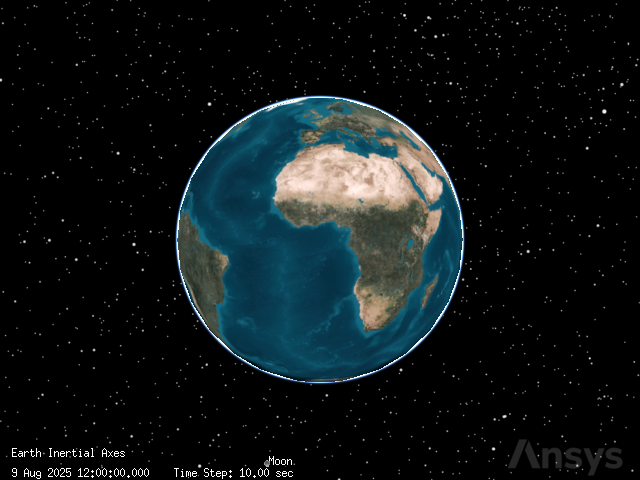

In [3]:
from ansys.stk.core.stkengine.experimental.jupyterwidgets import GlobeWidget


globe_plotter = GlobeWidget(root, 640, 480)
globe_plotter.show()

Show a 2D graphics window by running:

RFBOutputContext()

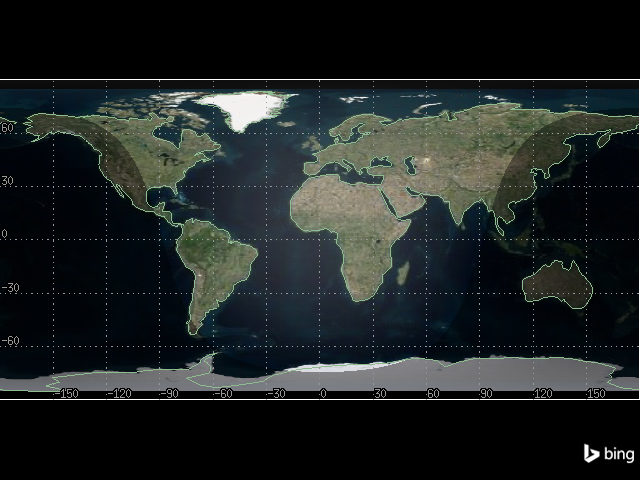

In [4]:
from ansys.stk.core.stkengine.experimental.jupyterwidgets import MapWidget


map_plotter = MapWidget(root, 640, 480)
map_plotter.show()

## Set the scenario time period

Using the newly created scenario, set the start and stop times. Rewind the scenario so that the graphics match the start and stop times of the scenario:

In [5]:
scenario = root.current_scenario
scenario.set_time_period("20 Jan 2020 17:00:00.000", "20 Jan 2020 19:00:00.000")
root.rewind()

## Configure the scenario graphics

To best display Aviator graphics, set the scenario's 3D graphics to use mean sea level as the surface reference:

In [6]:
from ansys.stk.core.stkobjects import SurfaceReference


scenario.graphics_3d.surface_reference = SurfaceReference.MEAN_SEA_LEVEL

## Add Oceana Naval Air Station

The aircraft leaves from Oceana Naval Air Station. Insert a facility object to represent the station:

In [7]:
from ansys.stk.core.stkobjects import STKObjectType


oceana_station = root.current_scenario.children.new(
    STKObjectType.FACILITY, "OceanaStation"
)

Configure the facility to use the scenario's terrain as its altitude reference:

In [8]:
oceana_station.use_terrain = True

Oceana Naval Air Station is located at a latitude of $36.822744^\circ$ and a longitude of $-76.031892^\circ$. Assign the facility to the correct location. Use an altitude of 0 so that the station's altitude is determined by terrain:

In [9]:
oceana_station.position.assign_geodetic(36.822744, -76.031892, 0.0)

## Add the USS Abraham Lincoln carrier ship

The aircraft lands on the USS Abraham Lincoln carrier ship, which is sailing off the coast near the Oceana Naval Air Station. Insert a ship object to represent the carrier:

In [10]:
carrier = root.current_scenario.children.new(STKObjectType.SHIP, "USSAbrahamLincoln")

The carrier is modeled with a Great Arc propagator, which propagates the ship's route based on waypoints. Assign a Great Arc propagator to the ship:

In [11]:
from ansys.stk.core.stkobjects import PropagatorType


carrier.set_route_type(PropagatorType.GREAT_ARC)

Configure the propagator to use terrain along the ship's route as the altitude reference for its waypoints:

In [12]:
from ansys.stk.core.stkobjects import VehicleAltitudeReference


carrier.route.set_altitude_reference_type(VehicleAltitudeReference.TERRAIN)

Next, define the distance between sampling points along the ship's route. This option is used when waypoint altitudes are referenced to terrain. Set the distance to $1$ km:

In [13]:
carrier.route.altitude_reference.granularity = 1

## Create the ship's route

The ship sails between 3 waypoints, located at ($36.64988281^\circ$, $-75.11230361^\circ$), ($36.63713768^\circ$, $-74.87339587^\circ$), and ($36.65454874^\circ$, $-75.29117133^\circ$). The ship has a constant speed of $0.01543333$ km/sec throughout its route.

Add the first waypoint to the ship's route and assign its location, speed, and altitude:

In [14]:
carrier_waypoints = {
    # name: [latitude, longitude, altitude, speed]
    "A": [36.64988281, -75.11230361, 0.0, 0.01543333],
    "B": [36.63713768, -74.87339587, 0.0, 0.01543333],
    "C": [36.65454874, -75.29117133, 0.0, 0.01543333],
}

In [15]:
for lat, lon, alt, spd in carrier_waypoints.values():
    waypoint = carrier.route.waypoints.add()
    waypoint.latitude = lat
    waypoint.longitude = lon
    waypoint.altitude = alt
    waypoint.speed = spd

Now, propagate the ship's route:

In [16]:
carrier.route.propagate()

It is now possible to view the Oceana Naval Air Station and the ship's route in the 2D graphics window:

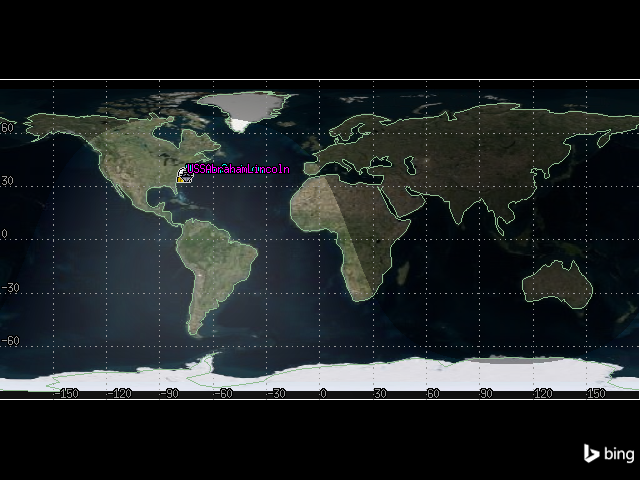

In [17]:
map_plotter.camera.position = [-3500, 34900, 0.0]
map_plotter.show()

## Add the lead aircraft

Two aircraft fly in formation from the Oceana Station to the USS Abraham Lincoln. Insert the first plane, which will lead the formation:

In [18]:
lead_aircraft = root.current_scenario.children.new(
    STKObjectType.AIRCRAFT, "LeadAircraft"
)

Next, set the aircraft's propagator to the Aviator propagator:

In [19]:
lead_aircraft.set_route_type(PropagatorType.AVIATOR)

Get the propagator object:

In [20]:
lead_propagator = lead_aircraft.route.aviator_propagator

All Aviator functions are available through the propagator, including accessing the aircraft's mission and planning its route, as well as accessing the Aviator catalogs. The lead aircraft is modeled by a Basic Fighter. To assign a Basic Fighter model to the aircraft, first get the Aviator aircraft model catalog:

In [21]:
aviator_catalog = lead_propagator.aviator_catalog
aircraft_models = aviator_catalog.aircraft_category.aircraft_models

Then, get the Basic Fighter model:

In [22]:
basic_fighter = aircraft_models.get_aircraft("Basic Fighter")

To assign the model to the aircraft, use the aircraft's mission. The mission describes the aircraft's route, as well as its performance characteristics and procedures. First, select the mission:

In [23]:
lead_mission = lead_propagator.aviator_mission

Then, assign the model as the mission's vehicle:

In [24]:
lead_mission.vehicle = basic_fighter

## Design the aircraft's route

Aviator missions are divided into phases, which are divided into procedures. A phase is a logical unit within a mission, while a procedure is a specific action that an aircraft executes. Each phase has its own performance models, which are used by any procedures contained in the phase.

Here, the lead aircraft flies a mission consisting of two phases. Select the first phase:

In [25]:
lead_phase1 = lead_mission.phases[0]

Get the procedures for the phase:

In [26]:
lead_procedures = lead_phase1.procedures

### Takeoff procedure

The aircraft first takes off from a runway at the Oceana Naval Air Station, so the first procedure consists of a takeoff from that runway. To insert the procedure, first load a catalog of runways in ARINC424 format into the Aviator runway catalog. The FAANFD18 file is included with the STK install.

In [27]:
import pathlib


runway_catalog = lead_propagator.aviator_catalog.runway_category
install_dir = root.execute_command("GetDirectory / STKHome")[0]
runway_catalog.arinc424_runways.master_data_filepath = str(
    pathlib.Path(install_dir)
    / "Data"
    / "Resources"
    / "stktraining"
    / "samples"
    / "FAANFD18"
)

Next, get the runway named "OCEANA NAS /APOLLO SOUCEK FIEL 05R 23L" from the Aviator runway catalog:  # codespell:ignore fiel

In [28]:
oceana_runway = runway_catalog.arinc424_runways.get_arinc424_item(
    "OCEANA NAS /APOLLO SOUCEK FIEL 05R 23L"  # codespell:ignore fiel
)

Next, add a takeoff procedure to the aircraft's first phase. The aircraft takes off from the Oceana runway in this procedure, so the procedure has a site type of runway and a procedure type of takeoff.

In [29]:
from ansys.stk.core.stkobjects.aviator import ProcedureType, SiteType


takeoff_procedure = lead_procedures.add(
    SiteType.SITE_RUNWAY, ProcedureType.PROCEDURE_TAKEOFF
)

Assign the catalog runway to the takeoff procedure as its takeoff site:

In [30]:
takeoff_procedure.site.copy_from_catalog(oceana_runway)
takeoff_procedure.site.name = (
    "OCEANA NAS /APOLLO SOUCEK FIEL 05R 23L"  # codespell:ignore fiel
)

Then, set the runway heading, which describes the direction the aircraft points on the runway. Set the heading to low:

In [31]:
from ansys.stk.core.stkobjects.aviator import RunwayHighLowEnd


takeoff_procedure.runway_heading_options.runway_mode = RunwayHighLowEnd.LOW_END

Then, set the takeoff mode to normal. In a normal takeoff, the aircraft pulls up off the runway and flies up to the departure altitude at the takeoff climb angle.

In [32]:
from ansys.stk.core.stkobjects.aviator import TakeoffMode


takeoff_procedure.takeoff_mode = TakeoffMode.TAKEOFF_NORMAL

Then, set the takeoff climb angle to $3^\circ$, the departure altitude to $500$ ft, and the runway altitude offset to $0$. To do so, use the takeoff procedure's `mode_as_normal` property, which converts the takeoff procedure to an `ITakeoffNormal` object:

In [33]:
takeoff_procedure.mode_as_normal.takeoff_climb_angle = 3
takeoff_procedure.mode_as_normal.departure_altitude = 500
takeoff_procedure.mode_as_normal.runway_altitude_offset = 0

Finally, enable the use of runway terrain in calculations:

In [34]:
takeoff_procedure.mode_as_normal.use_runway_terrain = True

### Enroute procedure

After takeoff, the aircraft flies an enroute procedure. An enroute procedure flies between the end of the previous procedure and the site of the current procedure, calculating trajectory and performance based on the aircraft's performance models. During the procedure, the aircraft climbs or descends to the specified altitude using the climb/descent model, and then cruises using the cruise model. An enroute procedure considers the specific heading at the end of the last procedure and sets the aircraft to a specified heading at the end of the current procedure. Enroute procedures are used for instrument flight rules or other controlled navigation, or when the flight path calls for a climb or descent to a constant altitude cruise.

In this case, an enroute procedure is used to begin the aircraft's approach to the ship. Insert an enroute procedure:

In [35]:
enroute_procedure = lead_procedures.add(
    SiteType.SITE_STK_OBJECT_WAYPOINT, ProcedureType.PROCEDURE_ENROUTE
)

The aircraft flies to the USS Abraham Lincoln in this procedure, so set the procedure's site to the ship:

In [36]:
enroute_procedure.site.object_name = "Ship/USSAbrahamLincoln"

Then, set the time at which the ship’s position is used as a waypoint on the aircraft's route. Set the time to the scenario's start time:

In [37]:
enroute_procedure.site.waypoint_time = scenario.start_time

Then, set the waypoint's offset mode, which offsets the site location relative from the STK Object. Set the mode to use a bearing/range relative to the aircraft's course:

In [38]:
from ansys.stk.core.stkobjects.aviator import STKObjectWaypointOffsetMode


enroute_procedure.site.offset_mode = (
    STKObjectWaypointOffsetMode.OFFSET_RELATIVE_BEARING_RANGE
)

Next, set the bearing offset to $180^\circ$ and the range offset to $40$ nm:

In [39]:
enroute_procedure.site.bearing = 180
enroute_procedure.site.range = 40

Then, set the procedure's altitude options. Disable the use of default cruise altitude during the procedure, and instead designate a fixed altitude of $20000$ ft:

In [40]:
enroute_procedure.altitude_msl_options.use_default_cruise_altitude = False
enroute_procedure.altitude_msl_options.msl_altitude = 20000

Finally, set the procedure's navigation options, which define the heading or course of the aircraft at the beginning of the procedure and the direction of the turns taken to arrive at the procedure site. Set the navigation mode to arrive on course, which means that the aircraft arrives at the procedure site on a specific course:

In [41]:
from ansys.stk.core.stkobjects.aviator import PointToPointMode


enroute_procedure.navigation_options.navigation_mode = PointToPointMode.ARRIVE_ON_COURSE

Then, set the aircraft to arrive on course at $135^\circ$:

In [42]:
enroute_procedure.navigation_options.arrive_on_course = 135

### Second enroute procedure

The aircraft then flies an additional enroute procedure to maintain its position after approaching the ship. Insert another enroute procedure:

In [43]:
enroute_procedure2 = lead_procedures.add(
    SiteType.SITE_STK_OBJECT_WAYPOINT, ProcedureType.PROCEDURE_ENROUTE
)

First, set the procedure's name to "Enter the stack":

In [44]:
enroute_procedure2.name = "Enter the stack"

Set the procedure's site to the USS Abraham Lincoln:

In [45]:
enroute_procedure2.site.object_name = "Ship/USSAbrahamLincoln"

The aircraft arrives at the ship at 17:09:06.858. Set the procedure's waypoint time:

In [46]:
enroute_procedure2.site.waypoint_time = "20 Jan 2020 17:09:06.858"

Set the procedure's waypoint offset mode to offset with a relative bearing and range, then set the relative bearing to $180^\circ$ and the relative range to $10$ nm:

In [47]:
enroute_procedure2.site.offset_mode = (
    STKObjectWaypointOffsetMode.OFFSET_RELATIVE_BEARING_RANGE
)
enroute_procedure2.site.bearing = 180
enroute_procedure2.site.range = 10

Then, disable the use of a default cruise altitude for the procedure, and set the altitude to $10000$ ft:

In [48]:
enroute_procedure2.altitude_msl_options.use_default_cruise_altitude = False
enroute_procedure2.altitude_msl_options.msl_altitude = 10000

Set the navigation mode to arrive on course for the next procedure:

In [49]:
enroute_procedure2.navigation_options.navigation_mode = (
    PointToPointMode.ARRIVE_ON_COURSE_FOR_NEXT
)

Then, set the enroute cruise airspeed speed type to max endurance airspeed. This option uses a variable airspeed to maximize the length of time that the aircraft can remain in flight.

In [50]:
from ansys.stk.core.stkobjects.aviator import CruiseSpeed


enroute_procedure2.enroute_cruise_airspeed_options.cruise_speed_type = (
    CruiseSpeed.MAX_ENDURANCE_AIRSPEED
)

## Second phase

After the aircraft's first phase, the aircraft meets its wing aircraft and keeps its station. Add the second phase in the lead aircraft's mission, which corresponds to the station keeping:

In [51]:
station_keeping_phase = lead_propagator.aviator_mission.phases.add()

Name the phase:

In [52]:
station_keeping_phase.name = "StationKeeping"

### Station keeping procedure

Then, add the first procedure in the phase, which is a basic maneuver from the end of the previous procedure:

In [53]:
station_keeping_basic_maneuver = station_keeping_phase.procedures.add(
    SiteType.SITE_END_OF_PREV_PROCEDURE, ProcedureType.PROCEDURE_BASIC_MANEUVER
)

Set the maneuver's strategy type to station keeping. This strategy is a horizontal plane strategy in which the aircraft orbits a point relative to a stationary or moving object, in this case the USS Abraham Lincoln.

In [54]:
station_keeping_basic_maneuver.navigation_strategy_type = "Stationkeeping"

Set the maneuver's target to the USS Abraham Lincoln:

In [55]:
station_keeping_basic_maneuver.navigation.target_name = "Ship/USSAbrahamLincoln"

Then, set the station options. The aircraft maintains a bearing relative to the ship of $-90^\circ$, holds a range of $2.7$ nm from the ship, flies while waiting on the station with a holding circle goal radius of $2.5$ nm, and turns left into the holding circle.

In [56]:
from ansys.stk.core.stkobjects.aviator import TurnDirection


station_keeping_basic_maneuver.navigation.relative_bearing = -90
station_keeping_basic_maneuver.navigation.relative_range = 2.7
station_keeping_basic_maneuver.navigation.desired_radius = 2.5
station_keeping_basic_maneuver.navigation.turn_direction = TurnDirection.TURN_LEFT

Next, set the maneuver's stopping condition, which dictates when the maneuver ends regardless of whether any other goals are met. Each maneuver requires at least one stopping condition, and stops if any of the conditions are met. Set the aircraft to stop after 5 turns:

In [57]:
from ansys.stk.core.stkobjects.aviator import StationkeepingStopCondition


station_keeping_basic_maneuver.navigation.stop_condition = (
    StationkeepingStopCondition.STOP_AFTER_TURN_COUNT
)
station_keeping_basic_maneuver.navigation.stop_after_turn_count = 5

Then, set the procedure to use a relative course instead of an absolute course, and set the course stop condition to $-180^\circ$:

In [58]:
station_keeping_basic_maneuver.navigation.use_relative_course = True
station_keeping_basic_maneuver.navigation.stop_course = -180

Next, configure the procedure's autopilot options. Set the autopilot strategy type to 'Autopilot - Vertical Plane' :

In [59]:
station_keeping_basic_maneuver.profile_strategy_type = "Autopilot - Vertical Plane"

Then, use the maneuver's `profile` property to access options for the Autopilot - Vertical Plane Strategy:

In [60]:
station_keeping_profile = station_keeping_basic_maneuver.profile

Next, configure the autopilot strategy. First, set the autopilot profile to use an absolute altitude of $2000$ ft by setting the autopilot altitude mode to specify altitude:

In [61]:
from ansys.stk.core.stkobjects.aviator import AutopilotAltitudeMode


station_keeping_profile.altitude_mode = AutopilotAltitudeMode.AUTOPILOT_SPECIFY_ALTITUDE
station_keeping_profile.absolute_altitude = 2000

Then, set a control altitude rate of $2000$ ft/min by first setting the altitude control mode:

In [62]:
from ansys.stk.core.stkobjects.aviator import AutopilotAltitudeControlMode


station_keeping_profile.altitude_control_mode = (
    AutopilotAltitudeControlMode.AUTOPILOT_ALTITUDE_RATE
)
station_keeping_profile.control_altitude_rate_value = 2000

Then, set the control limit mode to override the performance model value:

In [63]:
from ansys.stk.core.stkobjects.aviator import PerformanceModelOverride


station_keeping_profile.control_limit_mode = PerformanceModelOverride.OVERRIDE

Set the maximum pitch rate to $10^\circ$ and the damping ratio to $2$:

In [64]:
station_keeping_profile.max_pitch_rate = 10
station_keeping_profile.damping_ratio = 2

Finally, configure the profile's airspeed options, which designate the type of response Aviator has if the basic maneuver attempts to exceed the airspeed limit. Constrain the aircraft to not drop beneath its minimum speed limit, and not exceed its maximum speed limit:

In [65]:
from ansys.stk.core.stkobjects.aviator import (
    BasicManeuverAirspeedMode,
    BasicManeuverStrategyAirspeedPerformanceLimits,
)


station_keeping_profile.airspeed_options.airspeed_mode = (
    BasicManeuverAirspeedMode.MAINTAIN_MAX_ENDURANCE_AIRSPEED
)
station_keeping_profile.airspeed_options.min_speed_limits = (
    BasicManeuverStrategyAirspeedPerformanceLimits.CONSTRAIN_IF_VIOLATED
)
station_keeping_profile.airspeed_options.max_speed_limits = (
    BasicManeuverStrategyAirspeedPerformanceLimits.CONSTRAIN_IF_VIOLATED
)

Next, set the maneuver's flight mode, which designates the type of performance model that the aircraft uses to fly the maneuver. Set the flight mode to cruise:

In [66]:
from ansys.stk.core.stkobjects.aviator import PhaseOfFlight


station_keeping_basic_maneuver.flight_mode = PhaseOfFlight.FLIGHT_PHASE_CRUISE

Then, set the fuel flow type, which sets which performance model is used to calculate the fuel flow for the maneuver. Set the fuel flow type to cruise:

In [67]:
from ansys.stk.core.stkobjects.aviator import BasicManeuverFuelFlowType


station_keeping_basic_maneuver.fuel_flow_type = (
    BasicManeuverFuelFlowType.BASIC_MANEUVER_FUEL_FLOW_CRUISE
)

Next, configure the maneuver to stop when the aircraft reaches $2000$ lb of fuel:

In [68]:
station_keeping_basic_maneuver.use_stop_fuel_state = True
station_keeping_basic_maneuver.stop_fuel_state = 2000

Next, configure the maneuver's other stopping conditions. Disable the maximum flight time condition, enable the maximum downrange condition, and set the maximum downrange to $500$ nm:

In [69]:
station_keeping_basic_maneuver.use_max_time_of_flight = False
station_keeping_basic_maneuver.use_max_downrange = True
station_keeping_basic_maneuver.max_downrange = 500

Then, set the altitude limit mode to create an error if the aircraft exceeds the altitude limit during the maneuver:

In [70]:
from ansys.stk.core.stkobjects.aviator import BasicManeuverAltitudeLimit


station_keeping_basic_maneuver.altitude_limit_mode = (
    BasicManeuverAltitudeLimit.BASIC_MANEUVER_ALTITUDE_LIMIT_ERROR
)

Set the terrain impact mode to continue if its limit is reached:

In [71]:
station_keeping_basic_maneuver.terrain_impact_mode = (
    BasicManeuverAltitudeLimit.BASIC_MANEUVER_ALTITUDE_LIMIT_CONTINUE
)

### Relative course procedure

Next, the aircraft flies a constant relative course to the ship. Add another basic maneuver in the mission's second phase, starting from the end of the last procedure:

In [72]:
relative_course_basic_maneuver = station_keeping_phase.procedures.add(
    SiteType.SITE_END_OF_PREV_PROCEDURE, ProcedureType.PROCEDURE_BASIC_MANEUVER
)

Set the navigation strategy type to a relative course:

In [73]:
relative_course_basic_maneuver.navigation_strategy_type = "Relative Course"

Then, select the USS Abraham Lincoln as the procedure's target:

In [74]:
relative_course_basic_maneuver.navigation.target_name = "Ship/USSAbrahamLincoln"

Configure the maneuver to use a relative course of $0^\circ$:

In [75]:
relative_course_basic_maneuver.navigation.use_relative_course = True
relative_course_basic_maneuver.navigation.course = 0

Then, set the anchor offset options. Set the in track offset from the center of the target to $1$ nm:

In [76]:
relative_course_basic_maneuver.navigation.in_track = 1

Set the cross track offset from the center of the target to $0$ nm:

In [77]:
relative_course_basic_maneuver.navigation.cross_track = 0

Then, set the option to fly the base leg of the maneuver with a constant radius turn using the `use_approach_turn_mode` property. This option designates that the base leg of the maneuver is flown with a constant radius turn into the final (upwind) leg. When this option is set to false, two turns are performed, with the Maneuver Factor determining how aggressive the turns are.

In [78]:
relative_course_basic_maneuver.navigation.use_approach_turn_mode = True

Next, configure the procedure's closure mode, which defines the closure requirement for the maneuver. Set the closure mode to High Off Boresight, which indicates that the maneuver stops if closure stops, unless the aircraft is within the HOBs Max Angle Off and HOBs Angle Tolerance values:

In [79]:
from ansys.stk.core.stkobjects.aviator import ClosureMode


relative_course_basic_maneuver.navigation.closure_mode = ClosureMode.HOBS

Set the closure's downrange offset to $0$ nm and the maximum HOBs angle to $90^\circ$:

In [80]:
relative_course_basic_maneuver.navigation.downrange_offset = 0
relative_course_basic_maneuver.navigation.hobs_max_angle = 90

Next, set the maneuver's autopilot strategy to the vertical plane strategy:

In [81]:
relative_course_basic_maneuver.profile_strategy_type = "Autopilot - Vertical Plane"

Next, set the autopilot altitude options. Specify a constant absolute altitude of $800$ ft:

In [82]:
relative_course_basic_maneuver.profile.altitude_mode = (
    AutopilotAltitudeMode.AUTOPILOT_SPECIFY_ALTITUDE
)
relative_course_basic_maneuver.profile.absolute_altitude = 800

Set the altitude control mode to the control altitude rate mode, and specify a control altitude rate value of $2000$ ft/min:

In [83]:
relative_course_basic_maneuver.profile.altitude_control_mode = (
    AutopilotAltitudeControlMode.AUTOPILOT_ALTITUDE_RATE
)
relative_course_basic_maneuver.profile.control_altitude_rate_value = 2000

Next, set the control limit mode to override the performance model value:

In [84]:
relative_course_basic_maneuver.profile.control_limit_mode = (
    PerformanceModelOverride.OVERRIDE
)

Then, set the maximum pitch rate to $10^\circ$/s, and the damping ratio to $2$:

In [85]:
relative_course_basic_maneuver.profile.max_pitch_rate = 10
relative_course_basic_maneuver.profile.damping_ratio = 2

Next, set the autopilot airspeed options. Set the airspeed mode to maintain a specified airspeed of $350$ nm/hr, designated with calibrated airspeed:

In [86]:
from ansys.stk.core.stkobjects.aviator import (
    AirspeedType,
    BasicManeuverAirspeedMode,
)


relative_course_basic_maneuver.profile.airspeed_options.airspeed_mode = (
    BasicManeuverAirspeedMode.MAINTAIN_SPECIFIED_AIRSPEED
)
relative_course_basic_maneuver.profile.airspeed_options.specified_airspeed_type = (
    AirspeedType.CAS
)
relative_course_basic_maneuver.profile.airspeed_options.specified_airspeed = 350

Constrain the aircraft to not pass the minimum and maximum speed limits:

In [87]:
relative_course_basic_maneuver.profile.airspeed_options.min_speed_limits = (
    BasicManeuverStrategyAirspeedPerformanceLimits.CONSTRAIN_IF_VIOLATED
)
relative_course_basic_maneuver.profile.airspeed_options.max_speed_limits = (
    BasicManeuverStrategyAirspeedPerformanceLimits.CONSTRAIN_IF_VIOLATED
)

Next, set the flight mode and fuel flow type properties to use the cruise performance model:

In [88]:
relative_course_basic_maneuver.flight_mode = PhaseOfFlight.FLIGHT_PHASE_CRUISE
relative_course_basic_maneuver.fuel_flow_type = (
    BasicManeuverFuelFlowType.BASIC_MANEUVER_FUEL_FLOW_CRUISE
)

Then, set the procedure's stopping conditions. The procedure stops when the aircraft reaches $0$ lb of fuel, or a maximum downrange of $100$ nm, but does not have a constraint on time of flight. Set the conditions accordingly:

In [89]:
relative_course_basic_maneuver.use_stop_fuel_state = True
relative_course_basic_maneuver.stop_fuel_state = 0
relative_course_basic_maneuver.use_max_time_of_flight = False
relative_course_basic_maneuver.use_max_downrange = True
relative_course_basic_maneuver.max_downrange = 100

Finally, configure the procedure to create an error if the altitude limit is exceeded, but to continue if the terrain impact limit is exceeded:

In [90]:
relative_course_basic_maneuver.altitude_limit_mode = (
    BasicManeuverAltitudeLimit.BASIC_MANEUVER_ALTITUDE_LIMIT_ERROR
)
relative_course_basic_maneuver.terrain_impact_mode = (
    BasicManeuverAltitudeLimit.BASIC_MANEUVER_ALTITUDE_LIMIT_CONTINUE
)

### Second relative course maneuver

Add another relative course basic maneuver to the second phase of the mission. The procedure begins from the end of the last procedure.

In [91]:
relative_course_basic_maneuver2 = station_keeping_phase.procedures.add(
    SiteType.SITE_END_OF_PREV_PROCEDURE, ProcedureType.PROCEDURE_BASIC_MANEUVER
)

Set the navigation type to a relative course strategy:

In [92]:
relative_course_basic_maneuver2.navigation_strategy_type = "Relative Course"

Set the maneuver's target to the USS Abraham Lincoln:

In [93]:
relative_course_basic_maneuver2.navigation.target_name = "Ship/USSAbrahamLincoln"

Then, set the maneuver to use a relative course of $180^\circ$:

In [94]:
relative_course_basic_maneuver2.navigation.use_relative_course = True
relative_course_basic_maneuver2.navigation.course = 180

Then, set the anchor offset options. Set the in track offset from the center of the target to $0$ nm and the cross track offset from the center of the target to $-1.3$ nm:

In [95]:
relative_course_basic_maneuver2.navigation.in_track = 0
relative_course_basic_maneuver2.navigation.cross_track = -1.3

Then, set the option to fly the base leg of the maneuver with a constant radius turn using the `use_approach_turn_mode` property:

In [96]:
relative_course_basic_maneuver2.navigation.use_approach_turn_mode = True

Next, set the maneuver factor, which is a dimensionless factor that determines how tightly or gently the aircraft will maneuver. Set the maneuver factor to $1$, which represents an aggressive maneuver:

In [97]:
relative_course_basic_maneuver2.navigation.maneuver_factor = 1

Then, set the procedure's control limit to a maximum turn rate of $29.9725^\circ$/s:

In [98]:
from ansys.stk.core.stkobjects.aviator import (
    BasicManeuverStrategyNavigationControlLimit,
)


relative_course_basic_maneuver2.navigation.set_control_limit(
    BasicManeuverStrategyNavigationControlLimit.NAVIGATION_MAX_TURN_RATE, 29.9725
)

Next, set the closure options. Set the closure mode to High Off Boresight, the closure's downrange offset to $0$ nm and the maximum HOBs angle to $90^\circ$:

In [99]:
relative_course_basic_maneuver2.navigation.closure_mode = ClosureMode.HOBS
relative_course_basic_maneuver2.navigation.downrange_offset = 0
relative_course_basic_maneuver2.navigation.hobs_max_angle = 90

Next, set the maneuver's autopilot strategy to the vertical plane strategy:

In [100]:
relative_course_basic_maneuver2.profile_strategy_type = "Autopilot - Vertical Plane"

Next, set the autopilot altitude options. Specify a constant absolute altitude of $600$ ft:

In [101]:
relative_course_basic_maneuver2.profile.altitude_mode = (
    AutopilotAltitudeMode.AUTOPILOT_SPECIFY_ALTITUDE
)
relative_course_basic_maneuver2.profile.absolute_altitude = 600

Set the altitude control mode to the control altitude rate mode, and specify a control altitude rate value of $2000$ ft/min:

In [102]:
relative_course_basic_maneuver2.profile.altitude_control_mode = (
    AutopilotAltitudeControlMode.AUTOPILOT_ALTITUDE_RATE
)
relative_course_basic_maneuver2.profile.control_altitude_rate_value = 2000

Next, set the control limit mode to override the performance model value:

In [103]:
relative_course_basic_maneuver2.profile.control_limit_mode = (
    PerformanceModelOverride.OVERRIDE
)

Then, set the maximum pitch ratio to $10^\circ$, and the damping ratio to $2$:

In [104]:
relative_course_basic_maneuver2.profile.max_pitch_rate = 10
relative_course_basic_maneuver2.profile.damping_ratio = 2

Next, set the autopilot airspeed options. Set the airspeed mode to maintain a specified airspeed of $145$ nm/hr, designated with calibrated airspeed:

In [105]:
relative_course_basic_maneuver2.profile.airspeed_options.airspeed_mode = (
    BasicManeuverAirspeedMode.MAINTAIN_SPECIFIED_AIRSPEED
)
relative_course_basic_maneuver2.profile.airspeed_options.specified_airspeed_type = (
    AirspeedType.CAS
)
relative_course_basic_maneuver2.profile.airspeed_options.specified_airspeed = 145

Then, override the performance model's acceleration/deceleration, and instead designate a fixed acceleration/deceleration of $0.3$g:

In [106]:
relative_course_basic_maneuver2.profile.airspeed_options.specified_acceleration_deceleration_mode = PerformanceModelOverride.OVERRIDE
relative_course_basic_maneuver2.profile.airspeed_options.specified_acceleration_deceleration_g = 0.3

Constrain the aircraft to not pass the minimum and maximum speed limits:

In [107]:
relative_course_basic_maneuver2.profile.airspeed_options.min_speed_limits = (
    BasicManeuverStrategyAirspeedPerformanceLimits.CONSTRAIN_IF_VIOLATED
)
relative_course_basic_maneuver2.profile.airspeed_options.max_speed_limits = (
    BasicManeuverStrategyAirspeedPerformanceLimits.CONSTRAIN_IF_VIOLATED
)

Set the maneuver's flight mode and fuel flow type to cruise:

In [108]:
relative_course_basic_maneuver2.flight_mode = PhaseOfFlight.FLIGHT_PHASE_CRUISE
relative_course_basic_maneuver2.fuel_flow_type = (
    BasicManeuverFuelFlowType.BASIC_MANEUVER_FUEL_FLOW_CRUISE
)

Set the stopping conditions. Enable a fuel state stopping condition of $0$ lb, disable the maximum time of flight constraint, and enable a maximum downrange flight constraint of $50$ nm:

In [109]:
relative_course_basic_maneuver2.use_stop_fuel_state = True
relative_course_basic_maneuver2.stop_fuel_state = 0
relative_course_basic_maneuver2.use_max_time_of_flight = False
relative_course_basic_maneuver2.use_max_downrange = True
relative_course_basic_maneuver2.max_downrange = 50

Finally, set the procedure to create an error if the altitude limit is exceeded, but to continue if the terrain impact limit is exceeded:

In [110]:
relative_course_basic_maneuver2.altitude_limit_mode = (
    BasicManeuverAltitudeLimit.BASIC_MANEUVER_ALTITUDE_LIMIT_ERROR
)
relative_course_basic_maneuver2.terrain_impact_mode = (
    BasicManeuverAltitudeLimit.BASIC_MANEUVER_ALTITUDE_LIMIT_CONTINUE
)

### Landing procedure

After completing the station keeping procedures, the aircraft lands on the USS Abraham Lincoln. Add a basic maneuver starting from the end of the last procedure to correspond to the landing:

In [111]:
landing = station_keeping_phase.procedures.add(
    SiteType.SITE_END_OF_PREV_PROCEDURE, ProcedureType.PROCEDURE_BASIC_MANEUVER
)

Name the procedure:

In [112]:
landing.name = "Landing"

Then, set the procedure's navigation strategy to follow a relative course:

In [113]:
landing.navigation_strategy_type = "Relative Course"

Set the ship as the maneuver's target:

In [114]:
landing.navigation.target_name = "Ship/USSAbrahamLincoln"

Then, designate a relative course of $-9^\circ$:

In [115]:
landing.navigation.use_relative_course = True
landing.navigation.course = -9

Next, set the anchor offset using ft. Set the in track offset to $-850$ ft ($-0.139892$ nm), and the cross track offset to $75$ ft ($0.0123434$ nm):

In [116]:
landing.navigation.in_track = -0.139892
landing.navigation.cross_track = 0.0123434

Next, set the closure options. Set the closure mode to High Off Boresight, the closure's downrange offset to $0.1$ nm and the maximum HOBs angle to $90^\circ$:

In [117]:
landing.navigation.closure_mode = ClosureMode.HOBS
landing.navigation.downrange_offset = 0.1
landing.navigation.hobs_max_angle = 90

Then, set the autopilot strategy to use a relative flight path angle. The Relative Flight Path Angle strategy is a vertical plane strategy in which the aircraft flies a constant flight path angle relative to a stationary or cooperative moving object.

In [118]:
landing.profile_strategy_type = "Relative Flight Path Angle"

Set the flight path angle to $-3.5^\circ$:

In [119]:
landing.profile.flight_path_angle = -3.5

Set the anchor altitude offset, which is the height above or below the target that the aircraft attempts to achieve. Set the offset to $100$ ft:

In [120]:
landing.profile.anchor_altitude_offset = 100

Next, set the control limit, which constrains the aircraft's performance during the maneuver. Constrain the pitch rate, which represents the maximum rate at which the aircraft can climb or descend. Set the maximum pitch rate to $10^\circ$/s:

In [121]:
from ansys.stk.core.stkobjects.aviator import ProfileControlLimit


landing.profile.set_control_limit(ProfileControlLimit.PROFILE_PITCH_RATE, 10)

Then, set the profile's airspeed mode to maintain the current airspeed, defined in true airspeed:

In [122]:
landing.profile.airspeed_options.airspeed_mode = (
    BasicManeuverAirspeedMode.MAINTAIN_CURRENT_AIRSPEED
)
landing.profile.airspeed_options.maintain_airspeed_type = AirspeedType.TAS

Set the profile to constrain the aircraft to stay between its minimum and maximum speed limits:

In [123]:
landing.profile.airspeed_options.min_speed_limits = (
    BasicManeuverStrategyAirspeedPerformanceLimits.CONSTRAIN_IF_VIOLATED
)
landing.profile.airspeed_options.max_speed_limits = (
    BasicManeuverStrategyAirspeedPerformanceLimits.CONSTRAIN_IF_VIOLATED
)

Set the procedure to use the cruise performance model for its flight mode and fuel flow calculations:

In [124]:
landing.flight_mode = PhaseOfFlight.FLIGHT_PHASE_CRUISE
landing.fuel_flow_type = BasicManeuverFuelFlowType.BASIC_MANEUVER_FUEL_FLOW_CRUISE

Then, set the stopping conditions. Set a stopping condition of $0$ lb, disable the maximum time of flight condition, and set a maximum downrange condition of $50$ nm:

In [125]:
landing.use_stop_fuel_state = True
landing.stop_fuel_state = 0
landing.use_max_time_of_flight = False
landing.use_max_downrange = True
landing.max_downrange = 50

Finally, configure the maneuver to create an error if it exceeds its altitude limits, but continue if it passes its terrain impact limits:

In [126]:
landing.altitude_limit_mode = (
    BasicManeuverAltitudeLimit.BASIC_MANEUVER_ALTITUDE_LIMIT_ERROR
)
landing.terrain_impact_mode = (
    BasicManeuverAltitudeLimit.BASIC_MANEUVER_ALTITUDE_LIMIT_CONTINUE
)

## Propagate the lead aircraft

Now that the aircraft's mission has been created, propagate the aircraft:

In [127]:
lead_propagator.propagate()

It is now possible to see the aircraft's flight in the 2D graphics window:

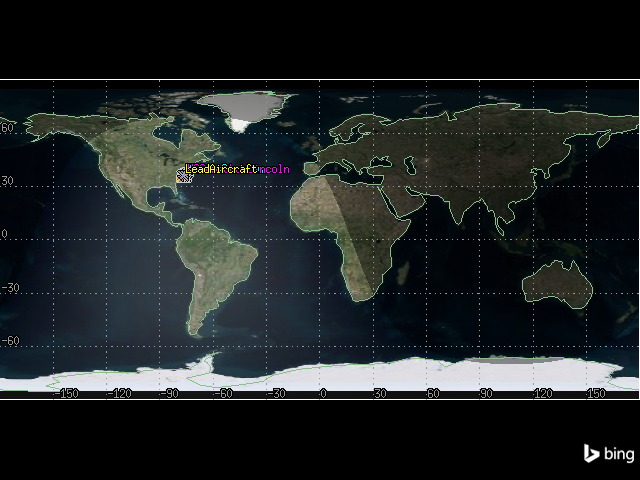

In [128]:
map_plotter.camera.position = [-3500, 34900, 0]
map_plotter.show()

## Add the wing aircraft

A second basic fighter wing aircraft flies in formation with the lead aircraft. Insert the wing aircraft:

In [129]:
wing_aircraft = scenario.children.new(STKObjectType.AIRCRAFT, "WingAircraft")

Assign an Aviator propagator to the aircraft:

In [130]:
wing_aircraft.set_route_type(PropagatorType.AVIATOR)
wing_propagator = wing_aircraft.route.aviator_propagator

### Configure the aircraft's mission

The wing aircraft is also modelled by a basic fighter jet. Assign the catalog basic fighter model as the mission's vehicle:

In [131]:
wing_propagator.aviator_mission.vehicle = basic_fighter

### First enroute procedure

The wing aircraft begins its involvement in the mission already in flight at a waypoint south of the lead aircraft. Thus, the aircraft's first procedure consists of an enroute procedure, starting from a designated waypoint. Insert the procedure:

In [132]:
wing_first_procedures = wing_propagator.aviator_mission.phases[0].procedures
wing_enroute = wing_first_procedures.add(
    SiteType.SITE_WAYPOINT, ProcedureType.PROCEDURE_ENROUTE
)

Name the procedure's site to "Waypoint":

In [133]:
wing_enroute.site.name = "Waypoint"

The wing aircraft starts from a waypoint with a latitude of $36.3174^\circ$ and a longitude of $-75.4974^\circ$. Assign these coordinates to the procedure's site:

In [134]:
wing_enroute.site.latitude = 36.3174
wing_enroute.site.longitude = -75.4974

Then, configure the procedure to use the mission's default cruise altitude:

In [135]:
wing_enroute.altitude_msl_options.use_default_cruise_altitude = True

Finally, set the procedure to arrive on course at $340.691^\circ$:

In [136]:
wing_enroute.navigation_options.navigation_mode = PointToPointMode.ARRIVE_ON_COURSE
wing_enroute.navigation_options.arrive_on_course = 340.691

### Basic maneuver to intercept lead aircraft

After the enroute procedure, the wing aircraft completes a basic maneuver to intercept the lead aircraft. Insert a basic maneuver procedure starting from the end of the last procedure:

In [137]:
wing_intercept = wing_first_procedures.add(
    SiteType.SITE_END_OF_PREV_PROCEDURE, ProcedureType.PROCEDURE_BASIC_MANEUVER
)

Name the maneuver:

In [138]:
wing_intercept.name = "Intercept Leader"

Set the maneuver's navigation strategy to a relative bearing strategy. A relative bearing strategy is a horizontal plane strategy in which the aircraft flies to a constant relative bearing to a stationary or moving object, in this case the lead aircraft. Set the navigation strategy type:

In [139]:
wing_intercept.navigation_strategy_type = "Relative Bearing"

Then, set the lead aircraft as the target, and configure the wing aircraft to intercept the lead with a relative bearing of $-20^\circ$ and a minimum range of $15$ nm:

In [140]:
wing_intercept.navigation.target_name = "Aircraft/LeadAircraft"
wing_intercept.navigation.relative_bearing = -20
wing_intercept.navigation.min_range = 15

Set the maneuver's control limit to use the control limits specified in the current acceleration performance model:

In [141]:
wing_intercept.navigation.set_control_limit(
    BasicManeuverStrategyNavigationControlLimit.NAVIGATION_USE_ACCELERATION_PERFORMANCE_MODEL,
    0,
)

Next, configure the maneuver's autopilot profile. Set the profile's strategy to a cruise type:

In [142]:
wing_intercept.profile_strategy_type = "Cruise Profile"

Then, configure the autopilot profile. Set the profile to use the Earth as its reference frame, and request an altitude of $18000$ ft:

In [143]:
from ansys.stk.core.stkobjects.aviator import BasicManeuverReferenceFrame


wing_intercept.profile.reference_frame = BasicManeuverReferenceFrame.EARTH_FRAME
wing_intercept.profile.requested_altitude = 18000

Configure the profile to use the maximum range airspeed:

In [144]:
from ansys.stk.core.stkobjects.aviator import CruiseSpeed


wing_intercept.profile.cruise_airspeed_options.cruise_speed_type = (
    CruiseSpeed.MAX_RANGE_AIRSPEED
)

Set the maneuver to use the cruise performance model for its flight mode and fuel flow calculations:

In [145]:
wing_intercept.flight_mode = PhaseOfFlight.FLIGHT_PHASE_CRUISE
wing_intercept.fuel_flow_type = (
    BasicManeuverFuelFlowType.BASIC_MANEUVER_FUEL_FLOW_CRUISE
)

Then, set a fuel state stopping condition of $0$ lb, and disable the maximum time of flight and maximum downrange conditions:

In [146]:
wing_intercept.use_stop_fuel_state = True
wing_intercept.stop_fuel_state = 0
wing_intercept.use_max_time_of_flight = False
wing_intercept.use_max_downrange = False

Finally, configure the maneuver to create an error if it passes its altitude limits, but continue if it violates its terrain impact limits:

In [147]:
wing_intercept.altitude_limit_mode = (
    BasicManeuverAltitudeLimit.BASIC_MANEUVER_ALTITUDE_LIMIT_ERROR
)
wing_intercept.terrain_impact_mode = (
    BasicManeuverAltitudeLimit.BASIC_MANEUVER_ALTITUDE_LIMIT_CONTINUE
)

### Rendezvous procedure

After the enroute procedure, the wing aircraft flies a rendezvous/formation basic maneuver to meet the wing aircraft. A rendezvous/formation strategy is a 3D strategy, operating in the wind frame, in which the aircraft uses multi-mode guidance to maintain formation with a cooperative aircraft, in this case the lead aircraft. The rendezvous/formation strategy assumes that the route of the leading aircraft is unknown and attempts to maintain formation by responding to the leading aircraft's maneuvering as it happens.

Insert a basic maneuver procedure beginning from the end of the previous procedure:

In [148]:
wing_rendezvous = wing_first_procedures.add(
    SiteType.SITE_END_OF_PREV_PROCEDURE, ProcedureType.PROCEDURE_BASIC_MANEUVER
)

Set a navigation strategy type of Rendezvous/Formation:

In [149]:
wing_rendezvous.navigation_strategy_type = "Rendezvous/Formation"

Name the procedure "Rendezvous":

In [150]:
wing_rendezvous.name = "Rendezvous"

Set the lead aircraft as the maneuver's target:

In [151]:
wing_rendezvous.navigation.target_name = "Aircraft/LeadAircraft"

Set the relative bearing, which is the bearing relative to the target that the aircraft achieves and maintains, the relative range, which is the range from the target that the aircraft achieves and maintains, and the altitude split, which is the altitude difference between the aircraft and the target. Set the relative bearing to $135^\circ$, the relative range to $0.25$ nm, and the altitude split to $100$ ft:

In [152]:
wing_rendezvous.navigation.relative_bearing = 135
wing_rendezvous.navigation.relative_range = 0.25
wing_rendezvous.navigation.altitude_split = 100

Next, set the maneuver factor, a dimensionless factor that influences how tightly or gently the aircraft will maneuver. At its most aggressive setting, the factor forces the strategy to achieve the specified performance values; at its most gentle setting, the factor allows the strategy to tolerate the most deviation from those values. Set the maneuver factor to $0.8$:

In [153]:
wing_rendezvous.navigation.maneuver_factor = 0.8

Then, enable the use of counter turn logic, which improves performance when flying with a target on a straight and level flight path. This option should be avoided if the target is flying a circular route.

In [154]:
wing_rendezvous.navigation.use_counter_turn_logic = True

Set the collision avoidance logic. Set the closest point of approach (CPA), which is the minimum distance between the aircraft and the reference aircraft that is maintained. The guidance strategy flies around a bubble of the specified radius, if necessary, to avoid violating the CPA. If the CPA is larger than the formation distance, then the formation distance overrides the CPA.

Set the CPA to $152.4$ nm:

In [155]:
wing_rendezvous.navigation.set_cpa(True, 152.4)

Then, set the maximum speed advantage, a limit to the airspeed difference between the aircraft and the target. Set the maximum speed advantage to $75$ nm/hr:

In [156]:
wing_rendezvous.navigation.max_speed_advantage = 75

Finally, set the maneuver to stop after the target completes the mission phase that it is performing when the aircraft rendezvous with it:

In [157]:
from ansys.stk.core.stkobjects.aviator import RendezvousStopCondition


wing_rendezvous.navigation.stop_condition = (
    RendezvousStopCondition.STOP_AFTER_TARGET_CURRENT_PHASE
)

There is no need to set the autopilot profile options, as profile settings are copied from the navigation settings when using 'Rendezvous/Formation' as the navigation mode.

Next, set the stopping conditions. Disable the fuel state and maximum time of flight constraints, and instead enable a maximum downrange stopping condition of $500$ nm:

In [158]:
wing_rendezvous.use_stop_fuel_state = False
wing_rendezvous.use_max_time_of_flight = False
wing_rendezvous.use_max_downrange = True
wing_rendezvous.max_downrange = 500

Finally, configure the procedure to create an error if the altitude limits are exceeded, but to continue if the terrain impact limits are reached:

In [159]:
wing_rendezvous.altitude_limit_mode = (
    BasicManeuverAltitudeLimit.BASIC_MANEUVER_ALTITUDE_LIMIT_ERROR
)
wing_rendezvous.terrain_impact_mode = (
    BasicManeuverAltitudeLimit.BASIC_MANEUVER_ALTITUDE_LIMIT_CONTINUE
)

### Stationkeeping procedure

After the rendezvous procedure, the wing aircraft keeps its station while flying in formation with the lead aircraft. Add a basic maneuver procedure, and assign it a stationkeeping navigation strategy type:

In [160]:
wing_stationkeeping = wing_first_procedures.add(
    SiteType.SITE_END_OF_PREV_PROCEDURE, ProcedureType.PROCEDURE_BASIC_MANEUVER
)
wing_stationkeeping.navigation_strategy_type = "Stationkeeping"

Next, set the USS Abraham Lincoln as the maneuver's target:

In [161]:
wing_stationkeeping.navigation.target_name = "Ship/USSAbrahamLincoln"

Configure the maneuver to maintain a relative bearing of $-90^\circ$, a relative range of $2.7$ nm, and a desired radius of $2.5$ nm:

In [162]:
wing_stationkeeping.navigation.relative_bearing = -90
wing_stationkeeping.navigation.relative_range = 2.7
wing_stationkeeping.navigation.desired_radius = 2.5

Set the maneuver's turn direction to turn left:

In [163]:
wing_stationkeeping.navigation.turn_direction = TurnDirection.TURN_LEFT

Next, set the maneuver's stop conditions so that the maneuver stops after a turn count of $5$:

In [164]:
wing_stationkeeping.navigation.stop_condition = (
    StationkeepingStopCondition.STOP_AFTER_TURN_COUNT
)
wing_stationkeeping.navigation.stop_after_turn_count = 5

Further configure the stopping conditions so that the maneuver stops after a relative course of $-180^\circ$:

In [165]:
wing_stationkeeping.navigation.use_relative_course = True
wing_stationkeeping.navigation.stop_course = -180

Next, assign a vertical plane strategy to the maneuver's autopilot profile:

In [166]:
wing_stationkeeping.profile_strategy_type = "Autopilot - Vertical Plane"

Configure the autopilot to maintain an absolute altitude of $3000$ ft:

In [167]:
wing_stationkeeping.profile.altitude_mode = (
    AutopilotAltitudeMode.AUTOPILOT_SPECIFY_ALTITUDE
)
wing_stationkeeping.profile.absolute_altitude = 3000

Then, set the autopilot to use an altitude control rate of $2000$ ft/min:

In [168]:
wing_stationkeeping.profile.altitude_control_mode = (
    AutopilotAltitudeControlMode.AUTOPILOT_ALTITUDE_RATE
)
wing_stationkeeping.profile.control_altitude_rate_value = 2000

Override the performance value's control limit:

In [169]:
wing_stationkeeping.profile.control_limit_mode = PerformanceModelOverride.OVERRIDE

Then, set the maximum pitch rate to $10^\circ$/s and the damping ratio to $2$:

In [170]:
wing_stationkeeping.profile.max_pitch_rate = 10
wing_stationkeeping.profile.damping_ratio = 2

Next, set the airspeed mode to maintain the maximum endurance airspeed for the aircraft, and constrain the aircraft to its minimum and maximum speed limits:

In [171]:
wing_stationkeeping.profile.airspeed_options.airspeed_mode = (
    BasicManeuverAirspeedMode.MAINTAIN_MAX_ENDURANCE_AIRSPEED
)
wing_stationkeeping.profile.airspeed_options.min_speed_limits = (
    BasicManeuverStrategyAirspeedPerformanceLimits.CONSTRAIN_IF_VIOLATED
)
wing_stationkeeping.profile.airspeed_options.max_speed_limits = (
    BasicManeuverStrategyAirspeedPerformanceLimits.CONSTRAIN_IF_VIOLATED
)

Configure the maneuver to use the cruise performance model for its flight mode and fuel flow calculations:

In [172]:
wing_stationkeeping.flight_mode = PhaseOfFlight.FLIGHT_PHASE_CRUISE
wing_stationkeeping.fuel_flow_type = (
    BasicManeuverFuelFlowType.BASIC_MANEUVER_FUEL_FLOW_CRUISE
)

Then, disable the fuel state and maximum time of flight stopping conditions, and enable a maximum downrange stopping condition of $500$ nm:

In [173]:
wing_stationkeeping.use_stop_fuel_state = False
wing_stationkeeping.use_max_time_of_flight = False
wing_stationkeeping.use_max_downrange = True
wing_stationkeeping.max_downrange = 500

Finally, configure the maneuver to create an error if the altitude limits are passed, but to continue if the terrain impact limits are reached:

In [174]:
wing_stationkeeping.altitude_limit_mode = (
    BasicManeuverAltitudeLimit.BASIC_MANEUVER_ALTITUDE_LIMIT_ERROR
)
wing_stationkeeping.terrain_impact_mode = (
    BasicManeuverAltitudeLimit.BASIC_MANEUVER_ALTITUDE_LIMIT_CONTINUE
)

### Second stationkeeping procedure

After the first stationkeeping procedure, the wing aircraft flies a second stationkeeping procedure to decrease its altitude. Insert a basic maneuver beginning from the end of the last procedure:

In [175]:
wing_stationkeeping2 = wing_first_procedures.add(
    SiteType.SITE_END_OF_PREV_PROCEDURE, ProcedureType.PROCEDURE_BASIC_MANEUVER
)

Assign a stationkeeping navigation strategy to the maneuver:

In [176]:
wing_stationkeeping2.navigation_strategy_type = "Stationkeeping"

Set the USS Abraham Lincoln as the maneuver's target:

In [177]:
wing_stationkeeping2.navigation.target_name = "Ship/USSAbrahamLincoln"

Then, set the maneuver's relative bearing to $-90^\circ$, relative range to $2.7$ nm, desired turn radius to $2.5$ nm, and turn direction to left:

In [178]:
wing_stationkeeping2.navigation.relative_bearing = -90
wing_stationkeeping2.navigation.relative_range = 2.7
wing_stationkeeping2.navigation.desired_radius = 2.5
wing_stationkeeping2.navigation.turn_direction = TurnDirection.TURN_LEFT

Next, configure the maneuver to stop after a single turn or after reaching a relative course of $-180^\circ$:

In [179]:
wing_stationkeeping2.navigation.stop_condition = (
    StationkeepingStopCondition.STOP_AFTER_TURN_COUNT
)
wing_stationkeeping2.navigation.stop_after_turn_count = 1
wing_stationkeeping2.navigation.use_relative_course = True
wing_stationkeeping2.navigation.stop_course = -180

Then, set a vertical plane autopilot strategy:

In [180]:
wing_stationkeeping2.profile_strategy_type = "Autopilot - Vertical Plane"

Configure the autopilot to maintain an altitude of $2000$ ft:

In [181]:
wing_stationkeeping2.profile.altitude_mode = (
    AutopilotAltitudeMode.AUTOPILOT_SPECIFY_ALTITUDE
)
wing_stationkeeping2.profile.absolute_altitude = 2000

Set the autopilot to maintain a control altitude rate of $2000$ ft/min:

In [182]:
wing_stationkeeping2.profile.altitude_control_mode = (
    AutopilotAltitudeControlMode.AUTOPILOT_ALTITUDE_RATE
)
wing_stationkeeping2.profile.control_altitude_rate_value = 2000

Then, override the performance model's control limits, and set a maximum pitch rate of $10^\circ$/s and a damping ratio of $2$:

In [183]:
wing_stationkeeping2.profile.control_limit_mode = PerformanceModelOverride.OVERRIDE
wing_stationkeeping2.profile.max_pitch_rate = 10
wing_stationkeeping2.profile.damping_ratio = 2

Configure the autopilot to maintain the maximum endurance airspeed and constrain the maneuver to the minimum and maximum speed limits:

In [184]:
wing_stationkeeping2.profile.airspeed_options.airspeed_mode = (
    BasicManeuverAirspeedMode.MAINTAIN_MAX_ENDURANCE_AIRSPEED
)
wing_stationkeeping2.profile.airspeed_options.min_speed_limits = (
    BasicManeuverStrategyAirspeedPerformanceLimits.CONSTRAIN_IF_VIOLATED
)
wing_stationkeeping2.profile.airspeed_options.max_speed_limits = (
    BasicManeuverStrategyAirspeedPerformanceLimits.CONSTRAIN_IF_VIOLATED
)

Configure the maneuver to use the cruise performance model for flight and fuel flow calculations:

In [185]:
wing_stationkeeping2.flight_mode = PhaseOfFlight.FLIGHT_PHASE_CRUISE
wing_stationkeeping2.fuel_flow_type = (
    BasicManeuverFuelFlowType.BASIC_MANEUVER_FUEL_FLOW_CRUISE
)

Set a fuel state stopping condition of $0$ lb, disable the maximum time of flight stopping condition, and set a maximum downrange condition of $500$ nm:

In [186]:
wing_stationkeeping2.use_stop_fuel_state = True
wing_stationkeeping2.stop_fuel_state = 0
wing_stationkeeping2.use_max_time_of_flight = False
wing_stationkeeping2.use_max_downrange = True
wing_stationkeeping2.max_downrange = 500

Finally, configure the maneuver to create an error upon passing altitude limits, but to continue if the terrain impact limits are met:

In [187]:
wing_stationkeeping2.altitude_limit_mode = (
    BasicManeuverAltitudeLimit.BASIC_MANEUVER_ALTITUDE_LIMIT_ERROR
)
wing_stationkeeping2.terrain_impact_mode = (
    BasicManeuverAltitudeLimit.BASIC_MANEUVER_ALTITUDE_LIMIT_CONTINUE
)

## Propagate the wing aircraft

Now that the wing aircraft's mission has been designed, propagate the aircraft:

In [188]:
wing_propagator.propagate()

The flights of both the lead and wing aircraft are now visible on the map widget:

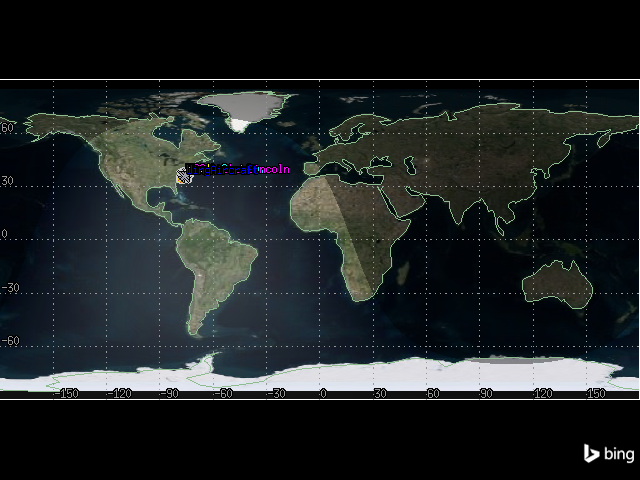

In [189]:
map_plotter.camera.position = [-3500, 34900, 0.0]
map_plotter.show()

## Determine when the lead aircraft lands

To determine when the lead aircraft lands, get the aircraft's Flight Profile By Time report, calculate the data over the duration of the scenario, with an interval of $60$ seconds, and convert the data to a pandas dataframe:

In [190]:
lead_flight_profile_df = (
    lead_aircraft.data_providers.item("Flight Profile By Time")
    .execute(scenario.start_time, scenario.stop_time, 60)
    .data_sets.to_pandas_dataframe()
)

The lead aircraft's landing time corresponds to the "time" column of the last row of the dataframe:

In [191]:
print(
    f"The lead aircraft lands at {lead_flight_profile_df.iloc[[-1]]['time'].values[0]}"
)

The lead aircraft lands at 20 Jan 2020 17:35:58.024586721


## Determine the wing aircraft's altitude when the lead aircraft lands

Get the wing aircraft's Flight Profile By Time report, calculate the data over the duration of the scenario, with an interval of $60$ seconds, and convert the data to a pandas dataframe:

In [192]:
wing_flight_profile_df = (
    wing_aircraft.data_providers.item("Flight Profile By Time")
    .execute(scenario.start_time, scenario.stop_time, 60)
    .data_sets.to_pandas_dataframe()
)

In [193]:
print(
    f"The wing aircraft has an altitude of {wing_flight_profile_df.iloc[[-1]]['altitude'].values[0]} ft when the lead aircraft lands."
)

The wing aircraft has an altitude of 1998.2352751375029 ft when the lead aircraft lands.


It is also possible to plot both the altitudes of both of the aircraft over their missions:

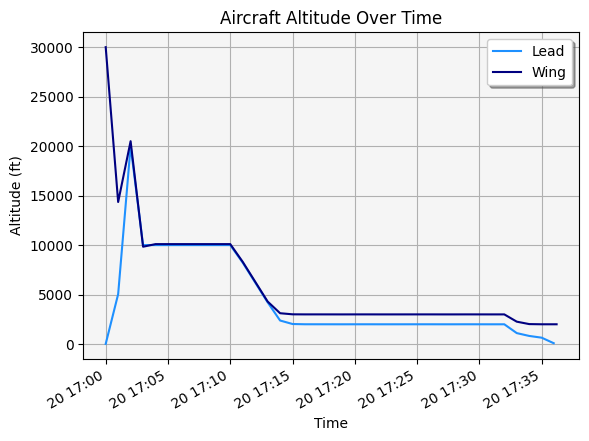

In [194]:
import matplotlib.pyplot as plt
import pandas as pd


# Convert data to correct types
lead_flight_profile_df["time"] = pd.to_datetime(lead_flight_profile_df["time"])
lead_flight_profile_df["altitude"] = pd.to_numeric(lead_flight_profile_df["altitude"])
wing_flight_profile_df["time"] = pd.to_datetime(wing_flight_profile_df["time"])
wing_flight_profile_df["altitude"] = pd.to_numeric(wing_flight_profile_df["altitude"])

# Plot data
ax = lead_flight_profile_df.plot(
    x="time", y="altitude", color="dodgerblue", label="Lead"
)
wing_flight_profile_df.plot(x="time", y="altitude", color="navy", label="Wing", ax=ax)

# Set title and axes labels
ax.set_title("Aircraft Altitude Over Time")
ax.set_xlabel("Time")
ax.set_ylabel("Altitude (ft)")

# Configure style
ax.set_facecolor("whitesmoke")
ax.grid(visible=True, which="both")
ax.legend(shadow=True)

plt.show()